# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell

## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
test_size = 0.2 # % of data saved as test
seed = 0 # seed for random train-test split

# NOTE: pass the same seed and test_size to load_data and to train_model_conv to train on the same train-test split as the one in the line below
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

6370107392/6370099814 [==============================] - 179s 0us/step
X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the Foreground/Background FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [5]:
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data
n_skips = 1  # number of skip-connections (only for FC training)

In [6]:
# pixelwise transform settings
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
pixelwise_kwargs = {
    'dilation_radius': dilation_radius,
    'separate_edge_classes': separate_edge_classes,
}

In [7]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

In [8]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'conv_fgbg_model'
pixelwise_model_name = 'conv_edgeseg_model'

n_epoch = 3  # Number of training epochs

fgbg_optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
pixelwise_optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

batch_size = 1  # fully convolutional training uses 1 image per batch

### Create the DataGenerators

The `ImageFullyConvDataGenerator` outputs a raw image (`X`) with it's labeled annotation mask (`y`). Additionally, it can apply a transform to `y` to change the task the model learns. Below we generate 2 training and validation data sets for both the foreground/background model and the pixelwise model.

In [9]:
from deepcell.image_generators import ImageFullyConvDataGenerator

datagen = ImageFullyConvDataGenerator(
    rotation_range=180,
    zoom_range=(.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = ImageFullyConvDataGenerator()

In [10]:
# Create the foreground/background data iterators

if isinstance(fgbg_model.output_shape, list):
    skip = len(fgbg_model.output_shape) - 1
else:
    skip = None

fgbg_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    skip=skip,
    transform='fgbg',
    batch_size=batch_size)

fgbg_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    skip=skip,
    transform='fgbg',
    batch_size=batch_size)

In [11]:
# Create the pixelwise data iterators

pixelwise_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    skip=n_skips,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    batch_size=batch_size)

pixelwise_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    skip=n_skips,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    batch_size=batch_size)

Visualize the data generator output.

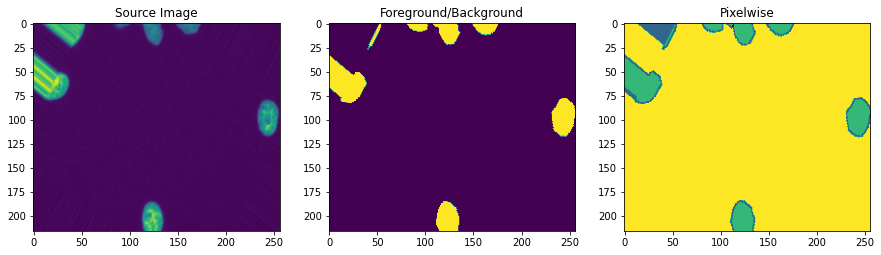

In [12]:
from matplotlib import pyplot as plt

# Different data generators but same data and same seed
img, fgbg_output = fgbg_train_data.next()
_, pixelwise_output = pixelwise_train_data.next()

if n_skips:
    fgbg_output = fgbg_output[0]
    pixelwise_output = pixelwise_output[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img[0, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(np.argmax(fgbg_output[0, ...], axis=-1))
ax[1].set_title('Foreground/Background')

ax[2].imshow(np.argmax(pixelwise_output[0, ...], axis=-1))
ax[2].set_title('Pixelwise')

plt.show()

### Compile the model with a loss function

Each model is trained with it's own loss function. `weighted_categorical_crossentropy` is often used for classification models, but `weighted_focal_loss` is also supported. The losses are passed to `model.compile` before training.

In [13]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=2,
        from_logits=False)

fgbg_model.compile(
    loss=loss_function,
    optimizer=fgbg_optimizer,
    metrics=['accuracy'])

## Train the foreground/background model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [14]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(fgbg_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = fgbg_model.fit(
    fgbg_train_data,
    steps_per_epoch=fgbg_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=fgbg_val_data,
    validation_steps=fgbg_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/3
5760/5760 [==============================] - ETA: 0s - loss: 0.1864 - functional_1_loss: 0.0852 - functional_3_loss: 0.0831 - functional_1_accuracy: 0.9679 - functional_3_accuracy: 0.9674
Epoch 00001: val_loss improved from inf to 0.14332, saving model to /data/models/conv_fgbg_model.h5
5760/5760 [==============================] - 292s 51ms/step - loss: 0.1864 - functional_1_loss: 0.0852 - functional_3_loss: 0.0831 - functional_1_accuracy: 0.9679 - functional_3_accuracy: 0.9674 - val_loss: 0.1433 - val_functional_1_loss: 0.0664 - val_functional_3_loss: 0.0587 - val_functional_1_accuracy: 0.9710 - val_functional_3_accuracy: 0.9728
Epoch 2/3
5759/5760 [============================>.] - ETA: 0s - loss: 0.1702 - functional_1_loss: 0.0780 - functional_3_loss: 0.0740 - functional_1_accuracy: 0.9709 - functional_3_accuracy: 0.9715
Epoch 00002: val_loss improved from 0.14332 to 0.14041, saving model to /data/models/conv_fgbg_model.h5
5760/5760 [===================

## Create the `pixelwise` FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [15]:
pixelwise_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    n_features=4 if separate_edge_classes else 3,
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

### Compile the model with a loss function

Just like the foreground/background model, the `pixelwise` model is compiled with the `weighted_categorical_crossentropy` loss function.

In [16]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=4 if separate_edge_classes else 3,
        from_logits=False)

pixelwise_model.compile(
    loss=loss_function,
    optimizer=pixelwise_optimizer,
    metrics=['accuracy'])

## Train the `pixelwise` model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [17]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(pixelwise_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(pixelwise_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = pixelwise_model.fit(
    pixelwise_train_data,
    steps_per_epoch=pixelwise_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=pixelwise_val_data,
    validation_steps=pixelwise_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/3
5760/5760 [==============================] - ETA: 0s - loss: 0.7317 - functional_7_loss: 0.3479 - functional_9_loss: 0.3468 - functional_7_accuracy: 0.9403 - functional_9_accuracy: 0.9367
Epoch 00001: val_loss improved from inf to 0.62468, saving model to /data/models/conv_edgeseg_model.h5
5760/5760 [==============================] - 404s 70ms/step - loss: 0.7317 - functional_7_loss: 0.3479 - functional_9_loss: 0.3468 - functional_7_accuracy: 0.9403 - functional_9_accuracy: 0.9367 - val_loss: 0.6247 - val_functional_7_loss: 0.2933 - val_functional_9_loss: 0.2940 - val_functional_7_accuracy: 0.9550 - val_functional_9_accuracy: 0.9515
Epoch 2/3
5760/5760 [==============================] - ETA: 0s - loss: 0.6558 - functional_7_loss: 0.3102 - functional_9_loss: 0.3079 - functional_7_accuracy: 0.9454 - functional_9_accuracy: 0.9439
Epoch 00002: val_loss improved from 0.62468 to 0.60807, saving model to /data/models/conv_edgeseg_model.h5
5760/5760 [=============

## Predict on test data

Use the trained model to predict on new data and post-process the results into a label mask.

In [18]:
test_images = pixelwise_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1440, 216, 256, 4)
segmentation mask shape: (1440, 216, 256, 2)


#### Post-processing

In [19]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

test_images_post_fgbg = test_images * fg_thresh

In [20]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(test_images_post_fgbg.shape[0]):
    interior = test_images_post_fgbg[i, ..., 2] > .2
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)

print('labeled_images shape:', labeled_images.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  # Remove the CWD from sys.path while we load stuff.


labeled_images shape: (1440, 216, 256, 1)


Image number: 399


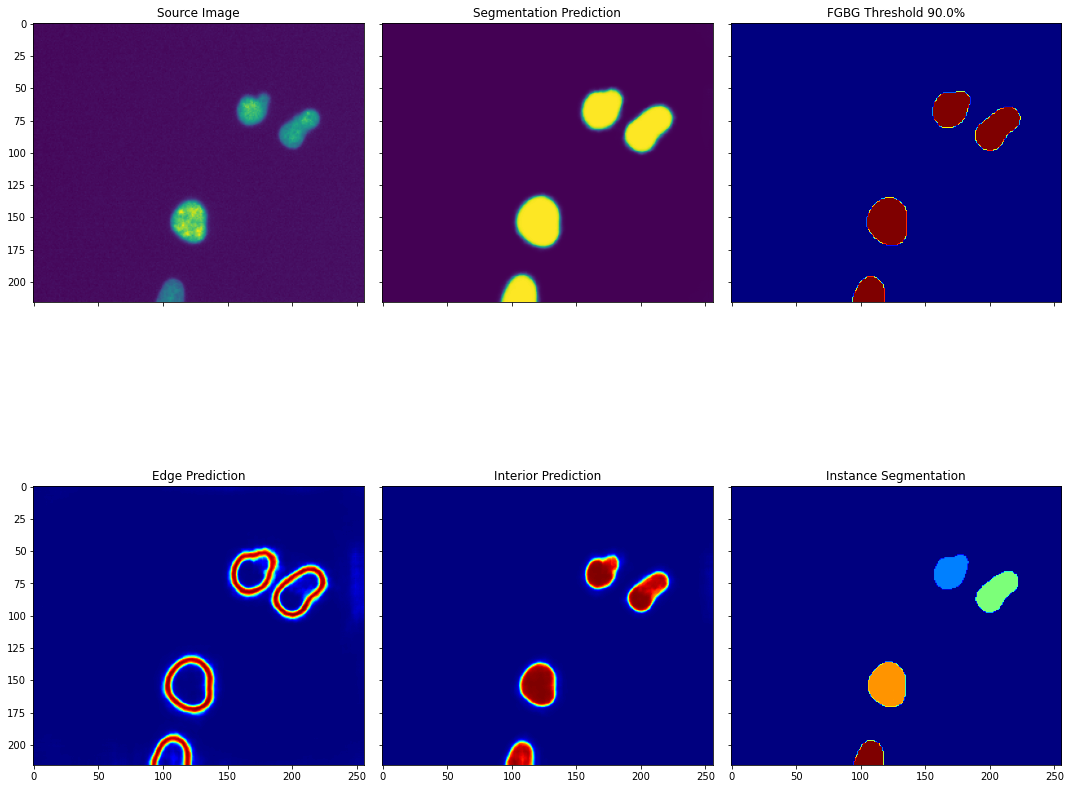

In [21]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')

fig.tight_layout()
plt.show()